# Intro
The purpose of this work is to replicate the results by PlanB in his article "Modeling Bitcoin's Value with Scarcity":

https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25

PlanB's GitHub page:

https://github.com/100trillionUSD

# Data

The dataset used in this exercise has been obtained as I explained in this other [Jupyter notebook](https://github.com/raulcano/bitcoin-analysis/blob/master/btc-dataset.ipynb).

I have purposedly used a different set than the one shared by PlanB in his GitHub page, in order to corroborate that there is no particular bias in the sources used by him.

Additionally, I  used a total of 1158 datapoints, in contrast with the 111 used by PlanB in the original article.
 
This is due to the granularity of the dataset, that is, I have used information on BTC prices and available supply almost on a daily basis (in particular, once every 3 days).

# Import libraries

In [1]:
!pip install sklearn
!pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as seabornInstance
import math
from datetime import timedelta

print('Libraries imported')

Libraries imported


# Building the dataframe
## Load dataframe from CSV file and remove unnecessary columns

Available columns are:

*id, hash, time, median_time, size, stripped_size, weight, version, version_hex, version_bits, merkle_root, nonce, bits, difficulty, chainwork, coinbase_data_hex, transaction_count, witness_count, input_count, output_count, input_total, input_total_usd, output_total, output_total_usd, fee_total, fee_total_usd, fee_per_kb, fee_per_kb_usd, fee_per_kwu, fee_per_kwu_usd, cdd_total, generation, generation_usd, reward, reward_usd, guessed_miner*

In [51]:
BLOCKS_DOWNLOAD_DIR = './blocks/'
ALL_BLOCKS_CSV = 'all_blocks.csv'

df = pd.read_csv(BLOCKS_DOWNLOAD_DIR + ALL_BLOCKS_CSV)
keep_col = ['id','time','generation']
df = df[keep_col]
df.head()

# If we want to save the new CSV with a subset of the columns to save memory loading next time
# df.to_csv(BLOCKS_DOWNLOAD_DIR + "all-blocks-reduced.csv", index=False)

,id,time,generation
0,0,2009-01-03 18:15:05,5000000000
1,1,2009-01-09 02:54:25,5000000000
2,2,2009-01-09 02:55:44,5000000000
3,3,2009-01-09 03:02:53,5000000000
4,4,2009-01-09 03:16:28,5000000000


## Let's get some info about the dataset

In [52]:
print(df.dtypes)
print(df.shape)

id             int64
time          object
generation     int64
dtype: object
(618575, 3)


## Remove potential duplicates based on the block ID

This is to avoid any potential duplication errors when obtaining the data

In [53]:
df.drop_duplicates(subset=['id'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,id,time,generation
0,0,2009-01-03 18:15:05,5000000000
1,1,2009-01-09 02:54:25,5000000000
2,2,2009-01-09 02:55:44,5000000000
3,3,2009-01-09 03:02:53,5000000000
4,4,2009-01-09 03:16:28,5000000000


In [54]:
df_orig = df

#df = df_orig

## Add column with the day each block was created



In [55]:
df['date'] = pd.to_datetime(df['time'])

df['date'] = df['date'].dt.date

df.head()

,id,time,generation,date
0,0,2009-01-03 18:15:05,5000000000,2009-01-03
1,1,2009-01-09 02:54:25,5000000000,2009-01-09
2,2,2009-01-09 02:55:44,5000000000,2009-01-09
3,3,2009-01-09 03:02:53,5000000000,2009-01-09
4,4,2009-01-09 03:16:28,5000000000,2009-01-09


## Group rows by day, add new calculated columns

Each row represents one day, with these new fields: 
- *btc_1day*: counts the BTC generated that day
- *btc_365days*: counts the BTC generated the last 365 days
- *total_btc*: represents the total number of BTC existing until that day
- *sf_365days*: represents the stock-to-flow in the last 365 days
- *ln_sf_365days*: the natural logarithm of SF 365
- *month*: the month column will be useful for some plotting later

In [56]:
df = df.groupby(['date']).agg(
    btc_1day = pd.NamedAgg(column='generation', aggfunc='sum'),
    daily_blocks =  pd.NamedAgg(column='date', aggfunc='count'),    
    ).reset_index()

# change from satoshis to BTC
df['btc_1day'] = df['btc_1day']/100000000

df['total_btc'] = df['btc_1day'].cumsum()
df['total_blocks'] = df['daily_blocks'].cumsum()
df['btc_365days'] = df['btc_1day'].rolling(min_periods=1, window=366).sum()
df['sf_365days'] = df['total_btc']/df['btc_365days']

df['ln_sf_365days'] = np.log(df['sf_365days']) # natural log of SF 365

df['month'] = pd.to_datetime(df['date'])
df['month'] = df['month'].dt.strftime('%Y-%m')

df.head(20)

,date,btc_1day,daily_blocks,total_btc,total_blocks,btc_365days,sf_365days,ln_sf_365days,month
0,2009-01-03,50.0,1,50.0,1,50.0,1.0,0.0,2009-01
1,2009-01-09,700.0,14,750.0,15,750.0,1.0,0.0,2009-01
2,2009-01-10,3050.0,61,3800.0,76,3800.0,1.0,0.0,2009-01
3,2009-01-11,4650.0,93,8450.0,169,8450.0,1.0,0.0,2009-01
4,2009-01-12,4700.0,94,13150.0,263,13150.0,1.0,0.0,2009-01
5,2009-01-13,6150.0,123,19300.0,386,19300.0,1.0,0.0,2009-01
6,2009-01-14,6450.0,129,25750.0,515,25750.0,1.0,0.0,2009-01
7,2009-01-15,6300.0,126,32050.0,641,32050.0,1.0,0.0,2009-01
8,2009-01-16,5400.0,108,37450.0,749,37450.0,1.0,0.0,2009-01
9,2009-01-17,5450.0,109,42900.0,858,42900.0,1.0,0.0,2009-01


## Add weighted BTC price

New fields: 
- *price*: weighted btc price weighted of that day
- *ln_price*: natural logarithm of the price
- *market_cap*: market value of all btc
- *ln_market_cap*: natural logarithm of the market cap

In [57]:
PRICE_DOWNLOAD_DIR = './price/'
ALL_PRICES_CSV = 'market-price-3day-interval.csv'

df_prices = pd.read_csv(PRICE_DOWNLOAD_DIR + ALL_PRICES_CSV, header=None, names=['date', 'price'])
df_prices['date'] = pd.to_datetime(df_prices['date'], format = '%d-%m-%y %H:%M')

df_prices['date'] = df_prices['date'].dt.date

df = pd.merge(df, df_prices, on='date', how='left')
df['ln_price'] = np.log(df['price'])
df['market_cap'] = df['price'] * df['total_btc']
df['ln_market_cap'] = np.log(df['market_cap'])

df.head()

,date,btc_1day,daily_blocks,total_btc,total_blocks,btc_365days,sf_365days,ln_sf_365days,month,price,ln_price,market_cap,ln_market_cap
0,2009-01-03,50.0,1,50.0,1,50.0,1.0,0.0,2009-01,0.0,-inf,0.0,-inf
1,2009-01-09,700.0,14,750.0,15,750.0,1.0,0.0,2009-01,0.0,-inf,0.0,-inf
2,2009-01-10,3050.0,61,3800.0,76,3800.0,1.0,0.0,2009-01,NaN,NaN,NaN,NaN
3,2009-01-11,4650.0,93,8450.0,169,8450.0,1.0,0.0,2009-01,NaN,NaN,NaN,NaN
4,2009-01-12,4700.0,94,13150.0,263,13150.0,1.0,0.0,2009-01,0.0,-inf,0.0,-inf


## Check distribution of NaN values

Because the data source we used gives a price every 3 days we have several NaN values in the price.

Also, the LN calculation with a price value of 0 results in -Infinite; this happens during the first months of BTC, in which no actual price quote was available.

We will replace all +-Inf values with NaN, and then plot the distribution of those values per date to see where we are missing more datapoints. It is expected that the first months of BTC will have less information about that.


In [58]:
df = df.replace([np.inf, -np.inf], np.nan)

# we create a dataframe subset only with the rows that DO have a NaN value
df_NaN = df[df.isnull().any(1)]
print('There are ' + str(df_NaN.shape[0]) + ' rows that contain at least one NaN value, from a total of ' + str(df.shape[0]) + ' rows')

# lets plot an histogram of those NaN values gruped by date
df_NaN = df_NaN.groupby(['month']).agg(
    monthly_NaN =  pd.NamedAgg(column='month', aggfunc='count'),
    ).reset_index()
    

There are 2905 rows that contain at least one NaN value, from a total of 4063 rows


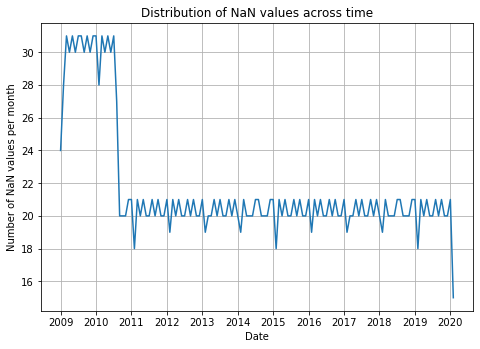

In [59]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(df_NaN['month'], df_NaN['monthly_NaN'])
ax.set_title('Distribution of NaN values across time')
ax.set_xlabel('Date')
ax.set_xticks(['2009-01','2010-01','2011-01','2012-01','2013-01','2014-01','2015-01','2016-01','2017-01','2018-01','2019-01','2020-01'])
ax.set_xticklabels(['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'])
ax.set_ylabel('Number of NaN values per month')
plt.grid(True, which="both")
plt.show()


![Stock-to-flow model for bitcoin price](images/1-distribution-nan.png)

## Remove NaN values and count total datapoints
We will ignore NaN datapoints in our calculation.

In [60]:
df = df.dropna()
print('Total datapoints: ' + str(df.shape[0]))

Total datapoints: 1158


# Plotting the data

In [61]:
#Text box with the credits
propstext = 'Model by PlanB, @100trillionUSD\n Chart by Raúl Cano, @rcanoarg'
propsbox = dict(boxstyle='round', facecolor='white', alpha=0.5)

## Linear scales

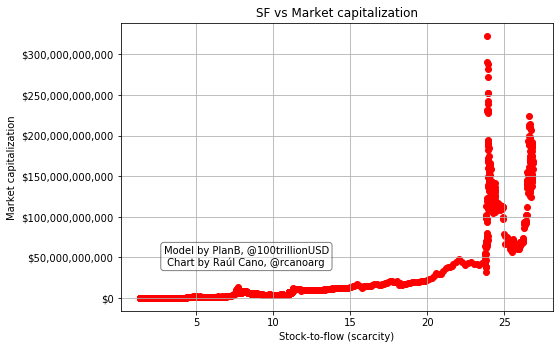

In [62]:
colors=['b', 'c', 'y', 'm', 'r']
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.scatter(df['sf_365days'], df['market_cap'], marker='o', color=colors[4])
ax.set_title('SF vs Market capitalization')
ax.set_xlabel('Stock-to-flow (scarcity)')
ax.set_ylabel('Market capitalization')

#ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
format = '${x:,.0f}'
tick = ticker.StrMethodFormatter(format)
ax.yaxis.set_major_formatter(tick) 
plt.grid(True, which="both")

# place the credits
ax.text(0.1, 0.15, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)

plt.show()


![Stock-to-flow model for bitcoin price](images/2-sf-v-marketcap.png)

## Log-log scales

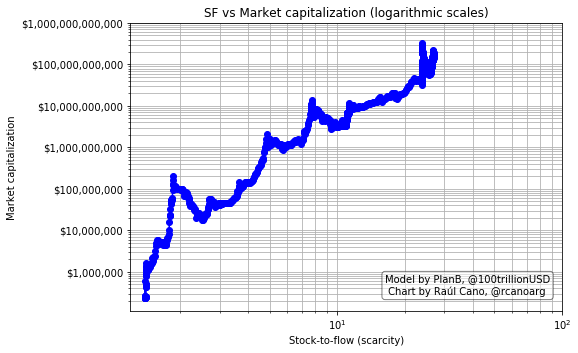

In [63]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.loglog(df['sf_365days'], df['market_cap'], marker='o', color=colors[0])
ax.set_title('SF vs Market capitalization (logarithmic scales)')
ax.set_xlabel('Stock-to-flow (scarcity)')

ax.set_ylabel('Market capitalization')
#ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
format = '${x:,.0f}'
tick = ticker.StrMethodFormatter(format)
ax.yaxis.set_major_formatter(tick)

ax.set_xlim([0,100])
ax.set_ylim([0,1000000000000])

# place the credits
ax.text(0.59, 0.05, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)

plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/3-sf-v-marketcap-ln.png)

# Linear regression

As we can see with the naked eye, there seems to be a  linear relationship between ln(SF) and ln(market cap).

Next, we will do a linear regression to obtain such relationship (using 90% of our dataset) and test it for errors against a test set (10% of our data).

In [64]:
X = df['ln_sf_365days'].values.reshape(-1,1)
y = df['ln_market_cap'].values.reshape(-1,1)

# split the dataset into traing and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

print('The linear function derived from the model is:')
print('ln(Market cap) = ' + str(round(regressor.coef_[0][0],2)) + '*ln(SF) + ' + str(round(regressor.intercept_[0],2)))

The linear function derived from the model is:
ln(Market cap) = 3.56*ln(SF) + 14.09


In [65]:
# Let's test the model with predictions
y_pred = regressor.predict(X_test)

df_linearR = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df_linearR


,Actual,Predicted
0,25.968433,25.777697
1,24.932662,25.708403
2,24.372984,25.382603
3,20.696358,19.646115
4,25.242080,25.743856
...,...,...
111,22.102018,22.208253
112,22.635118,21.451860
113,23.386226,23.773784
114,22.278484,22.646785


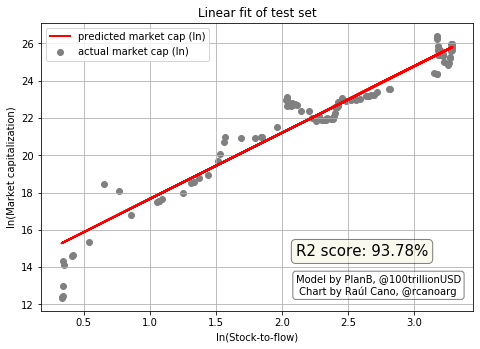

In [66]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.scatter(X_test, y_test, color='gray')
ax.plot(X_test, y_pred, color='red', linewidth=2)

ax.set_title('Linear fit of test set')
ax.legend(('predicted market cap (ln)','actual market cap (ln)'),
    loc="upper left",
    ncol=1,
    fontsize=10)


ax.set_xlabel('ln(Stock-to-flow)')
ax.set_ylabel('ln(Market capitalization)')

#Text box
textstr = 'R2 score: ' + str(round(metrics.r2_score(y_test, y_pred),4)*100) + '%'
box = dict(boxstyle='round', facecolor='beige', alpha=0.5)
# place a text box
ax.text(0.59, 0.18, textstr, transform=ax.transAxes, fontsize=15,
    verticalalignment='bottom', bbox=box)
# place the credits
ax.text(0.59, 0.05, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)


plt.grid(True, which="both")
plt.show()


![Stock-to-flow model for bitcoin price](images/4-linear-fit.png)

# Metrics of the model
The final step is to evaluate the performance of the algorithm. This step is particularly important to compare how well different algorithms perform on a particular dataset. For regression algorithms, three evaluation metrics are commonly used:

- Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
- Mean Squared Error (MSE) is the mean of the squared errors.
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.
- Coefficient of determination (R2) mathematically describes the strength of a correlation between two variables.

In [67]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Coefficient of determination: ', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.5830507922058059
Mean Squared Error: 0.7100496135652934
Root Mean Squared Error: 0.8426444170379896
Coefficient of determination:  0.9378339336027857


# Applying the model to our dataframe

In [68]:
df['predicted_ln_market_cap'] = regressor.coef_[0][0] * df['ln_sf_365days'] + regressor.intercept_[0]
df['predicted_market_cap'] = np.exp(df['predicted_ln_market_cap'])
df['predicted_price'] = df['predicted_market_cap'] / df['total_btc']
df['ln_predicted_price'] = np.log(df['predicted_price'])
df['abs_error'] = abs(df['predicted_price'] - df['price'])
df['percentage_error'] = df['abs_error'] / df['price']

df['abs_error_ln'] = abs(df['ln_price'] - df['ln_predicted_price'])
df['percentage_error_ln'] = df['abs_error_ln'] / df['ln_price']

df['abs_error_market_cap_ln'] = abs(df['ln_market_cap'] - df['predicted_ln_market_cap'])
df['percentage_error_market_cap_ln'] = df['abs_error_market_cap_ln'] / df['ln_market_cap']

In [69]:
df.tail(200)

,date,btc_1day,daily_blocks,total_btc,total_blocks,btc_365days,sf_365days,ln_sf_365days,month,price,...,predicted_ln_market_cap,predicted_market_cap,predicted_price,ln_predicted_price,abs_error,percentage_error,abs_error_ln,percentage_error_ln,abs_error_market_cap_ln,percentage_error_market_cap_ln
3463,2018-07-03,1449.999999,116,1.712961e+07,530371,705306.249981,24.286767,3.189932,2018-07,6626.44,...,25.451251,1.130675e+11,6600.704962,8.794932,25.735038,0.003884,0.003891,0.000442,0.003891,0.000153
3466,2018-07-06,1999.999946,160,1.713500e+07,530802,704793.749872,24.312072,3.190973,2018-07,6555.51,...,25.454960,1.134877e+11,6623.153771,8.798327,67.643771,0.010319,0.010266,0.001168,0.010266,0.000403
3469,2018-07-09,1699.999999,136,1.714062e+07,531252,704731.249872,24.322209,3.191390,2018-07,6724.04,...,25.456446,1.136564e+11,6630.820679,8.799484,93.219321,0.013864,0.013961,0.001584,0.013961,0.000548
3472,2018-07-12,1762.500000,141,1.714593e+07,531677,703693.749818,24.365619,3.193173,2018-07,6403.18,...,25.462798,1.143807e+11,6671.007445,8.805526,267.827445,0.041827,0.040976,0.004675,0.040976,0.001612
3475,2018-07-15,1662.500000,133,1.715105e+07,532086,702893.749818,24.400624,3.194609,2018-07,6248.84,...,25.467912,1.149671e+11,6703.212895,8.810342,454.372895,0.072713,0.070191,0.008031,0.070191,0.002764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,2020-02-08,1737.500000,139,1.820715e+07,616574,681474.999999,26.717262,3.285310,2020-02,9807.54,...,25.791018,1.588170e+11,8722.781545,9.073693,1084.758455,0.110605,0.117213,0.012753,0.117213,0.004524
4051,2020-02-11,1850.000000,148,1.821243e+07,616997,681099.999999,26.739735,3.286151,2020-02,9854.79,...,25.794013,1.592934e+11,8746.406939,9.076398,1108.383061,0.112472,0.119315,0.012975,0.119315,0.004604
4054,2020-02-14,1687.500000,135,1.821766e+07,617415,680999.999999,26.751334,3.286584,2020-02,10242.43,...,25.795558,1.595396e+11,8757.417409,9.077656,1485.012591,0.144986,0.156638,0.016963,0.156638,0.006036
4057,2020-02-17,1962.500000,157,1.822317e+07,617856,681287.499999,26.748136,3.286465,2020-02,9937.67,...,25.795132,1.594717e+11,8751.040997,9.076928,1186.629003,0.119407,0.127160,0.013816,0.127160,0.004905


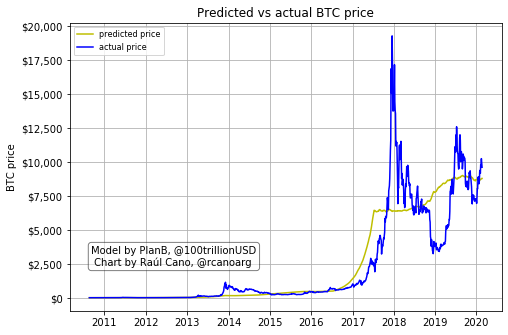

In [70]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(df['date'], df['predicted_price'], color=colors[2])
ax.plot(df['date'], df['price'], color=colors[0])
ax.set_title('Predicted vs actual BTC price')
ax.legend(('predicted price','actual price'),
    loc="upper left",
    ncol=1,
    fontsize=8)

ax.set_ylabel('BTC price')
format = '${x:,.0f}'
tick = ticker.StrMethodFormatter(format)
ax.yaxis.set_major_formatter(tick)

# place the credits
ax.text(0.05, 0.15, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)

plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/5-predicted-v-actual.png)

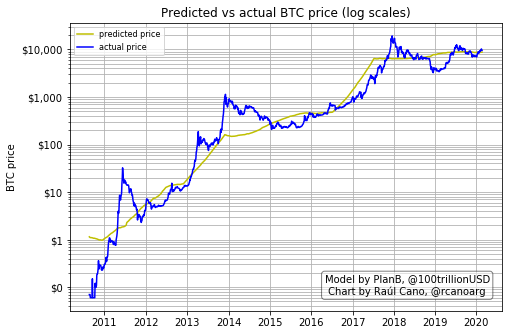

In [71]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.semilogy(df['date'], df['predicted_price'], color=colors[2])
ax.semilogy(df['date'], df['price'], color=colors[0])
ax.set_title('Predicted vs actual BTC price (log scales)')
ax.legend(('predicted price','actual price'),
    loc="upper left",
    ncol=1,
    fontsize=8)

ax.set_ylabel('BTC price')
format = '${x:,.0f}'
tick = ticker.StrMethodFormatter(format)
ax.yaxis.set_major_formatter(tick)

# place the credits
ax.text(0.59, 0.05, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)
plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/5-predicted-v-actual-ln.png)

## Percentage of error over the logarithm of BTC price

This shows that the SF model predicts very accurately the logarithm of the BTC price based on the logarithm of the SF value.

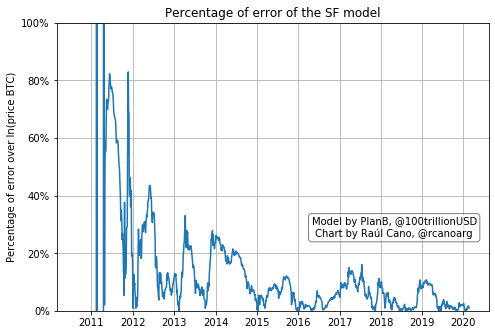

In [72]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(df['date'], df['percentage_error_ln'])
ax.set_title("Percentage of error of the SF model")
ax.set_ylabel("Percentage of error over ln(price BTC)")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.set_ylim([0,1])
# place the credits
ax.text(0.59, 0.25, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)
plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/6-percentage-error-ln.png)

## Percentage of error over the BTC price

Unfortunately, as we see here, the accurate prediction of the ln(BTC price) does not translate very well to the prediction of the BTC price.

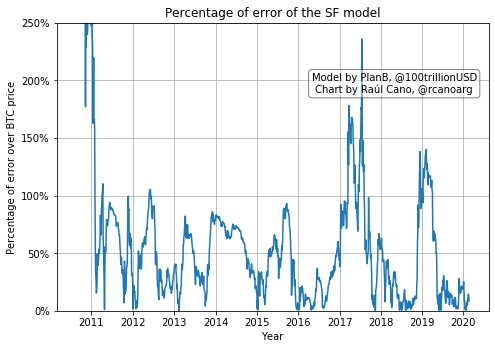

In [73]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.plot(df['date'], df['percentage_error'])

ax.set_title("Percentage of error of the SF model")
ax.set_xlabel("Year")
ax.set_ylabel("Percentage of error over BTC price")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax.set_ylim([0,2.5])
# place the credits
ax.text(0.59, 0.75, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)
plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/7-percentage-error.png)

## Plotting together predicted price and error

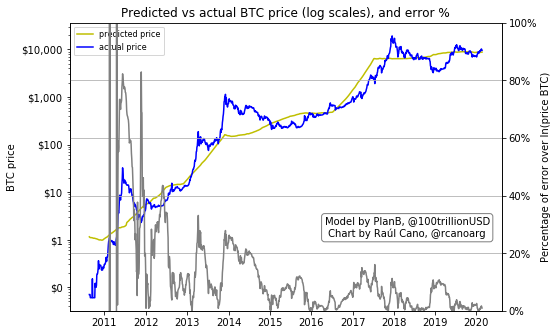

In [74]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.semilogy(df['date'], df['predicted_price'], color=colors[2])
ax.semilogy(df['date'], df['price'], color=colors[0])
ax.set_title('Predicted vs actual BTC price (log scales), and error %')
ax.legend(('predicted price','actual price'),
    loc="bottom right",
    ncol=1,
    fontsize=8)

ax.set_ylabel('BTC price')
format = '${x:,.0f}'
tick = ticker.StrMethodFormatter(format)
ax.yaxis.set_major_formatter(tick)


# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df['date'], df['percentage_error_ln'], color='gray')
ax2.set_xlabel("Year")
ax2.set_ylabel("Percentage of error over ln(price BTC)")
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.set_ylim([0,1])

# place the credits
ax.text(0.59, 0.25, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)
plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/8-predicted-v-actual-v-error.png)

# Predictions for the future

Let's expand the dataset with the normal rate of creation of blocks and fill the values with the prediction.

For this part, we create range of dates between last date in the original dataframe and a few years later on. See the following variables to change the range at your will

In [75]:
day_increment = 3 # Change this if future datasets require different period
years_in_the_future = 2 # Change this at will

def get_btc_block_reward(block_number):
    initial_reward = 50
    blocks_per_halving = 210000
    number_of_halvings = int(block_number/blocks_per_halving)
    return initial_reward / pow(2,number_of_halvings)

In [76]:
df_future = pd.DataFrame()

# blocks generated per day on average
average_blocks_per_day = int(round(df["daily_blocks"].mean(),0))
last_known_amount_blocks = df['total_blocks'].max()
last_known_amount_btc = df['total_btc'].max()

# future dates
periods = years_in_the_future * 365 / day_increment
start_date = df.date.max() + timedelta(days=day_increment)
future_dates = pd.date_range(start=start_date, periods=periods, freq=str(day_increment)+'D')

# create a new df with the same structure of the current one
# this way it's easier to merge both later if needed
df_future = df.iloc[0:0]

df_future['date'] = future_dates
df_future['date'] = df_future['date'].dt.date
df_future['daily_blocks'] = average_blocks_per_day
df_future['total_blocks'] = (df_future['daily_blocks']*day_increment).cumsum() + last_known_amount_blocks
df_future['btc_1day'] = df_future['total_blocks']
df_future['btc_1day'] = df_future['btc_1day'].apply(lambda x: get_btc_block_reward(x)) * df_future['daily_blocks']
df_future['total_btc'] = (df_future['btc_1day']*day_increment).cumsum() + last_known_amount_btc
df_future['month'] = pd.to_datetime(df_future['date'])
df_future['month'] = df_future['month'].dt.strftime('%Y-%m')

# we need to concatenate with the df dataframe to make use of the values there
df_future =  pd.concat([df, df_future])

# This one has to be generated with data from the df dataframe
df_future['btc_365days'] = df_future['btc_1day'].rolling(min_periods=1, window=int(366/day_increment)).sum()*day_increment

# Now we derive everything else
df_future['sf_365days'] = df_future['total_btc']/df_future['btc_365days']
df_future['ln_sf_365days'] = np.log(df_future['sf_365days']) # natural log of SF 365

df_future['predicted_ln_market_cap'] = regressor.coef_[0][0] * df_future['ln_sf_365days'] + regressor.intercept_[0]
df_future['predicted_market_cap'] = np.exp(df_future['predicted_ln_market_cap'])
df_future['predicted_price'] = df_future['predicted_market_cap'] / df_future['total_btc']
df_future['ln_predicted_price'] = np.log(df_future['predicted_price'])

# This is to retrieve the actual values which were modified by the wrangling we did with the future ones
df1 = df_future.iloc[:df.shape[0], :]
df2 = df_future.iloc[df.shape[0]:, :]
df_future =  pd.concat([df, df2])
#df_future.to_csv('df_future.csv')

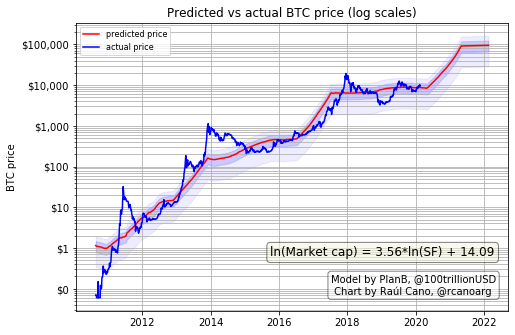

In [98]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes
ax.semilogy(df_future['date'], df_future['predicted_price'], color=colors[4])
ax.semilogy(df_future['date'], df_future['price'], color=colors[0])
ax.set_title('Predicted vs actual BTC price (log scales)')
ax.legend(('predicted price','actual price'),
    loc="upper left",
    ncol=1,
    fontsize=8)

ax.set_ylabel('BTC price')
format = '${x:,.0f}'
tick = ticker.StrMethodFormatter(format)
ax.yaxis.set_major_formatter(tick)

error = 0.3 * df_future['predicted_price']
ax.fill_between(df_future['date'], df_future['predicted_price']-error, df_future['predicted_price']+error, alpha=.15, color='blue')
error2 = 0.7 * df_future['predicted_price']
ax.fill_between(df_future['date'], df_future['predicted_price']-error2, df_future['predicted_price']+error2, alpha=.07, color='blue')
# 
function_text = 'ln(Market cap) = ' + str(round(regressor.coef_[0][0],2)) + '*ln(SF) + ' + str(round(regressor.intercept_[0],2))
box = dict(boxstyle='round', facecolor='beige', alpha=0.5)
# place a text box
ax.text(0.45, 0.18, function_text, transform=ax.transAxes, fontsize=12,
    verticalalignment='bottom', bbox=box)

# place the credits
ax.text(0.59, 0.05, propstext, transform=ax.transAxes, fontsize=10,
    verticalalignment='bottom', bbox=propsbox)
plt.grid(True, which="both")
plt.show()

![Stock-to-flow model for bitcoin price](images/9-predicted-future.png)

# Conclusions

As you can see in the previous charts and regression data, the original work of PlanB has been replicated successfully.
Not only that, I used a dataset 10 times bigger than the original one and the logarithmic relationship between SF and Market capitalization of bitcoin holds (he used the average value of BTC per month, while we have used one data point each 3 days).
In this case, the value of the linear relationship are only slighly different:

```
ln(Market cap) = 3.56*ln(SF) + 14.09
```

The SF model for BTC price predicts very accurately the logarithm of the BTC price based on the logarithm of the SF value, with an error of less than 20% most of the time. However, this accurate prediction does not translate well to the prediction of the BTC price, which ranges wildly from very low error to values in the range of 100% / 200%.

Additionally, it also encouraging that the work done here has used different sources of data and tools than the ones he used in PlanB's paper.
The price dataset used in this exercise has limited the granularity to at least one datapoint each 3 days. As soon as more data are available, we can run this again and obtain updated results.




# References

\[1\] Modeling Bitcoin's Value with Scarcity

https://medium.com/@100trillionUSD/modeling-bitcoins-value-with-scarcity-91fa0fc03e25

\[2\] Building a bitcoin dataset

https://medium.com/burgercrypto-com/building-a-bitcoin-dataset-b2f526d667ce

\[3\] Aggregation and grouping data

https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

\[4\] Joining and merging dataframes in pandas

https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

\[5\] A beginner's guide to linear regression

https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

\[6\] How to make histograms in Python

https://cmdlinetips.com/2019/02/how-to-make-histogram-in-python-with-pandas-and-seaborn/

\[7\] API reference for the Axes class for plotting

https://matplotlib.org/3.1.0/api/axes_api.html